# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

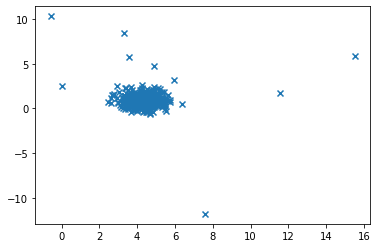

In [0]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m*sum_
    
    # compute variance of X
    var = 1/m*np.sum((X-mu)**2,axis=0)
    
    return mu,var
mu, sigma = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

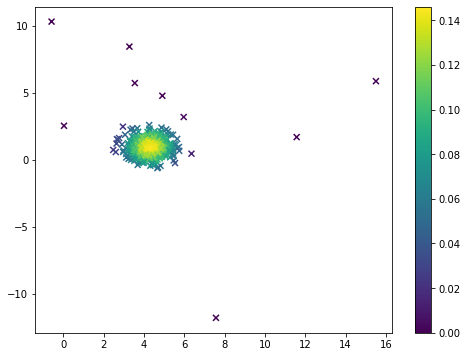

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

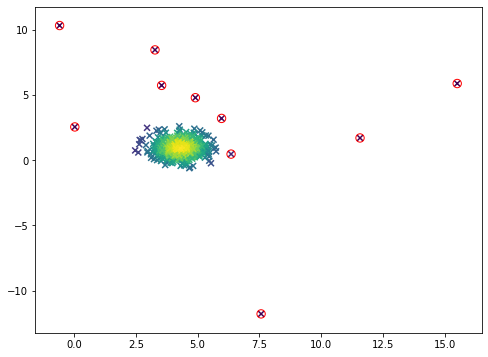

In [0]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the lowest value of K for which we get precision of 1.0 (should read "What is the highest value of K for which we get precision of 1.0?)? ____**Solution: 10**
* What is the precision for K=4? ____**Solution: 1**

In [0]:
from sklearn.metrics import precision_score
for i in range(0,15):

    mn = sorted(p)[i]

    sc = precision_score(y_true, 1*(p<=mn))
    print('K is ',i+1, ', precision is', sc)

K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 1.0
K is  11 , precision is 0.9090909090909091
K is  12 , precision is 0.8333333333333334
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7142857142857143
K is  15 , precision is 0.6666666666666666


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

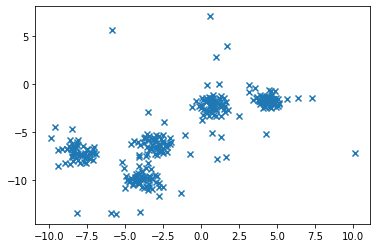

In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]]) # change y_ture to 0 and y_true_append to 1
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? ___**--> Solution: Precision is 1**
* k=10? ___**--> Solution: Precision is 0.9**
* k=100? ___**--> Solution: Precision is 0.13**

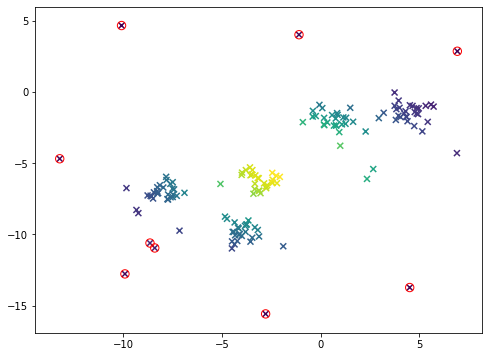

In [0]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

In [0]:
# Solution Code: calcualte K at 10 and 100
from sklearn.metrics import precision_score
mn = sorted(p)[0]
sc = precision_score(y_test, 1*(p<=mn))
print('K is ',1, ', precision is', sc)

mn = sorted(p)[9]
sc = precision_score(y_test, 1*(p<=mn))
print('K is ',10, ', precision is', sc)

mn = sorted(p)[99]
sc = precision_score(y_test, 1*(p<=mn))
print('K is ',100, ', precision is', sc)

K is  1 , precision is 1.0
K is  10 , precision is 0.9
K is  100 , precision is 0.13


Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [0]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

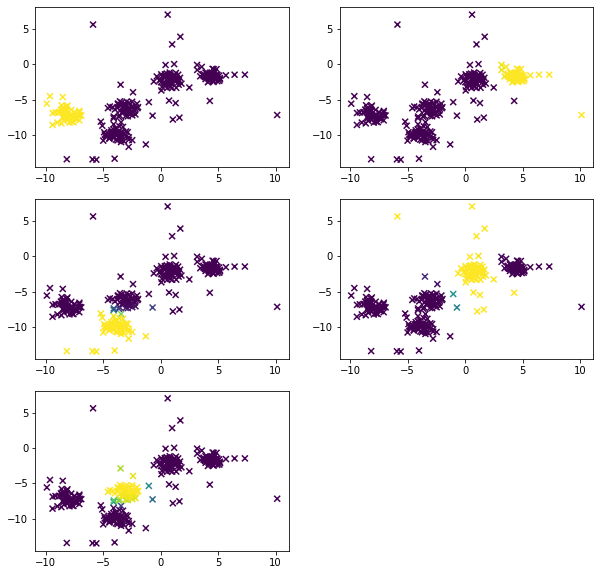

In [0]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.
**--> Solution: for score_sample it precisions are:  k=1, precision =1; k=10, precision=1 ; k=100, precision = 0.18**
* Is this model better or worse performing than the previous? ___**-->Solutions: The model pridect_prab is worse than the previous one.**
* Why might that be? ____ **-->solutions: This is mainly because 'predict_proba' shows the probablity that a particular data point belogns to a particular cluster, but not the probablity of the point being generated by a cluster.**

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


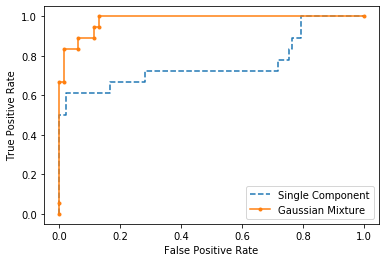

In [0]:
                          '''    Inserted code copied from the Quercus.   '''
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#This part outputs the precision and recall on the test set
p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [0]:
#ps = gm.predict_proba(X_test)

In [0]:
# Solutions:
'''I = np.ones(ps.shape) # create an matrix that has 1 with shape sames a ps (149,5)
p2=np.ones(ps.shape[0])-np.prod(I-ps,axis=1) # calcualte propability and p2 has a shape: (149,)'''

from sklearn.metrics import precision_score

# when k =1, 
mn=np.sort(p_gm)[0]
sc = precision_score(y_test,1*(p_gm<=mn))
print('K is',1,', preceision is',sc)

# when k =10, 
mn=np.sort(p_gm)[9]
sc = precision_score(y_test,1*(p_gm<=mn))
print('K is',10,', preceision is',sc)

# when k =100, 
mn=np.sort(p_gm)[99]
sc=precision_score(y_test,1*(p_gm<=mn))
print('K is',100,', preceision is',sc)

K is 1 , preceision is 1.0
K is 10 , preceision is 1.0
K is 100 , preceision is 0.18


Although our MoG model doesn't perfectly identify all the outliers, (ignore:it performs way better than our previous model,) again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [0]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-11-21 16:42:21--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-11-21 16:42:22--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle’

simpsons.pickle     100%[===================>]  25.46K  --.-KB/s    in 0.01s   

2019-11-21 16:42:22 (2.15 MB/s) - ‘simpsons.pickle’ saved [26076/26076]



With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? __**--> Solution: the modal rating is around 7.4**
* What is the range of ratings? __**--> Solution: the range is from 4 to 9.3**

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  9.,  0.,  1.,  1.,
         1.,  1.,  2.,  6., 11.,  4., 15., 18., 26., 17., 24., 37., 37.,
        33., 36., 40., 43., 27., 22., 11., 29., 24., 19., 18., 13., 24.,
        27., 19., 14., 11., 14.,  7.,  9.,  3.,  6.,  6.,  2.]),
 array([4.   , 4.106, 4.212, 4.318, 4.424, 4.53 , 4.636, 4.742, 4.848,
        4.954, 5.06 , 5.166, 5.272, 5.378, 5.484, 5.59 , 5.696, 5.802,
        5.908, 6.014, 6.12 , 6.226, 6.332, 6.438, 6.544, 6.65 , 6.756,
        6.862, 6.968, 7.074, 7.18 , 7.286, 7.392, 7.498, 7.604, 7.71 ,
        7.816, 7.922, 8.028, 8.134, 8.24 , 8.346, 8.452, 8.558, 8.664,
        8.77 , 8.876, 8.982, 9.088, 9.194, 9.3  ]),
 <a list of 50 Patch objects>)

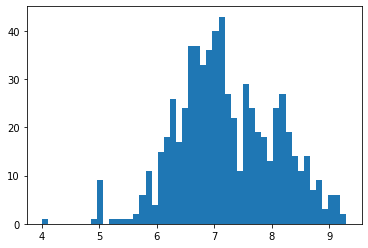

In [0]:
season = []
ratings=[]
names=[]
for season_number,sim_rating in simpsons.items():
  season.append(season_number)
  for key in sim_rating: 
   ratings.append(sim_rating[key])
plt.hist(ratings,bins=50)

Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? __**--> Solutions: the means are 6.77 and 8.17**
* What about the standard deviations? __ **--> Solutions: the standard deviations are 0.596 and 0.474**

In [0]:
import math
ratings = np.array(ratings).reshape(-1,1)
from sklearn.mixture import GaussianMixture
gm=GaussianMixture(n_components=2,covariance_type='full',random_state=0,)

gm.fit(ratings)
print("means: ",gm.means_)
print("Standard deviations; ",math.sqrt(gm.covariances_[0]),math.sqrt(gm.covariances_[1]))

means:  [[6.7734211 ]
 [8.17942889]]
Standard deviations;  0.5968930283014954 0.47412260237406


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? _**--> Solution: the notable drop-off point is at season 10, which has 10 good ratings**
* When is the first season with 0 good episodes? __**--> Solution: the first season with no good ratings is season 15**

Season: 1 Number of Good Ratings 9
Season: 2 Number of Good Ratings 18
Season: 3 Number of Good Ratings 24
Season: 4 Number of Good Ratings 21
Season: 5 Number of Good Ratings 21
Season: 6 Number of Good Ratings 24
Season: 7 Number of Good Ratings 24
Season: 8 Number of Good Ratings 24
Season: 9 Number of Good Ratings 20
Season: 10 Number of Good Ratings 10
Season: 11 Number of Good Ratings 4
Season: 12 Number of Good Ratings 5
Season: 13 Number of Good Ratings 4
Season: 14 Number of Good Ratings 1
Season: 15 Number of Good Ratings 0
Season: 16 Number of Good Ratings 0
Season: 17 Number of Good Ratings 0
Season: 18 Number of Good Ratings 1
Season: 19 Number of Good Ratings 1
Season: 20 Number of Good Ratings 0
Season: 21 Number of Good Ratings 0
Season: 22 Number of Good Ratings 0
Season: 23 Number of Good Ratings 2
Season: 24 Number of Good Ratings 0
Season: 25 Number of Good Ratings 1
Season: 26 Number of Good Ratings 1
Season: 27 Number of Good Ratings 1
Season: 28 Number of Good Ra

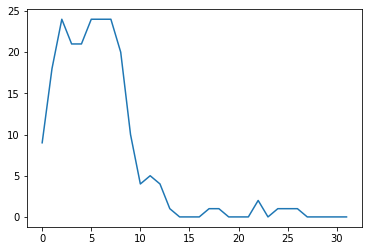

In [0]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
rating_list=[] # create a list to accumated the number of good rating
for season, episode_rating in simpsons.items(): # access to season # --> epsiode and rating
  good=0 # set good to zero everytime when enter the second loop
  for episode,score in episode_rating.items(): # access to epidoe, ratings seperately 
      
      score = np.array(score).reshape(-1,1) # convert to numpy array type for the next step
      
      if gm.predict(score)==1:
        good+=1
  rating_list.append(good)
  print('Season:',season,'Number of Good Ratings',good)
plt.plot(rating_list)

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] _____**--> Solution: 284807 rows**
* What features in the dataset are present aside from the 28 main features?[1] _____**--> Solutions: There are time, amount and class**
* Why do you think the main features are given to us in this way?[1] _____**--> Solution: the main features are principal components obtained with PCA. Due to the confidentiality issues, the original features of the data cannot be given to us.**
* Which column contains the targets? Can you figure out what the values correspond to?[1] _____**--> Solutions: THe 'Class' column contains targets which are 0 and 1**

In [0]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=61523fa6ad1839d513bd526b2e41b32c988e797d1d794d273e717b507b9419f1
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [0]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
# Solution:
df=pd.read_csv('creditcard.csv')
# number of rows
print(len(df))
# first 5 rows of the data
print(df.head())

284807
   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0

[5 rows x 31 columns]




```
# This is formatted as code
```

It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] _____**--> Solutions: 0.998 for 0 class and 0.0017 for 1 class**
* Why might this pose a problem with methods we have looked at so far?[1] _____**--> Solutions: we have a huge set of data with only very small percentage of frauduelent tractions (Class = 1). This could bring some probelms when fitting models and obtaining the precision score.**



In [0]:
# Percentage of entriess in the dataset for each class
print('Class 0:',(df['Class']==0).sum(axis=0)/len(df))
print('Class 1:',(df['Class']==1).sum(axis=0)/len(df))

Class 0: 0.9982725143693799
Class 1: 0.001727485630620034


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] _____**--> Solutions: mean is 0.000294 and standard deviation is 0.6048**

Use the code below to set up a Gaussian object for V24.

In [0]:
#solution:

X_true = df.iloc[:,1:29]
y_true=df['Class']
# split the data 
X_train, X_test, y_train, y_test = train_test_split(X_true, y_true, test_size=0.33, random_state=0, shuffle=True)

In [0]:
# Calcualte the mean and standard deviation
import statistics
a = np.array(X_train['V24'].values).reshape(1,-1)
mu=a.mean()
std=np.std(a)
print('mean:',mu)
print('standard deviation:',std)

mean: 0.0002942484069872569
standard deviation: 0.6048626021215933


In [0]:
from scipy import stats

norm = stats.norm(loc=mu,scale=std
    
)

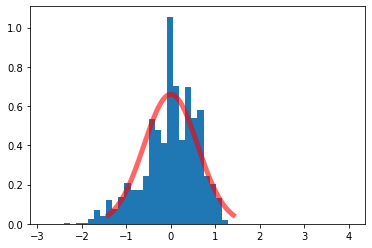

In [0]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

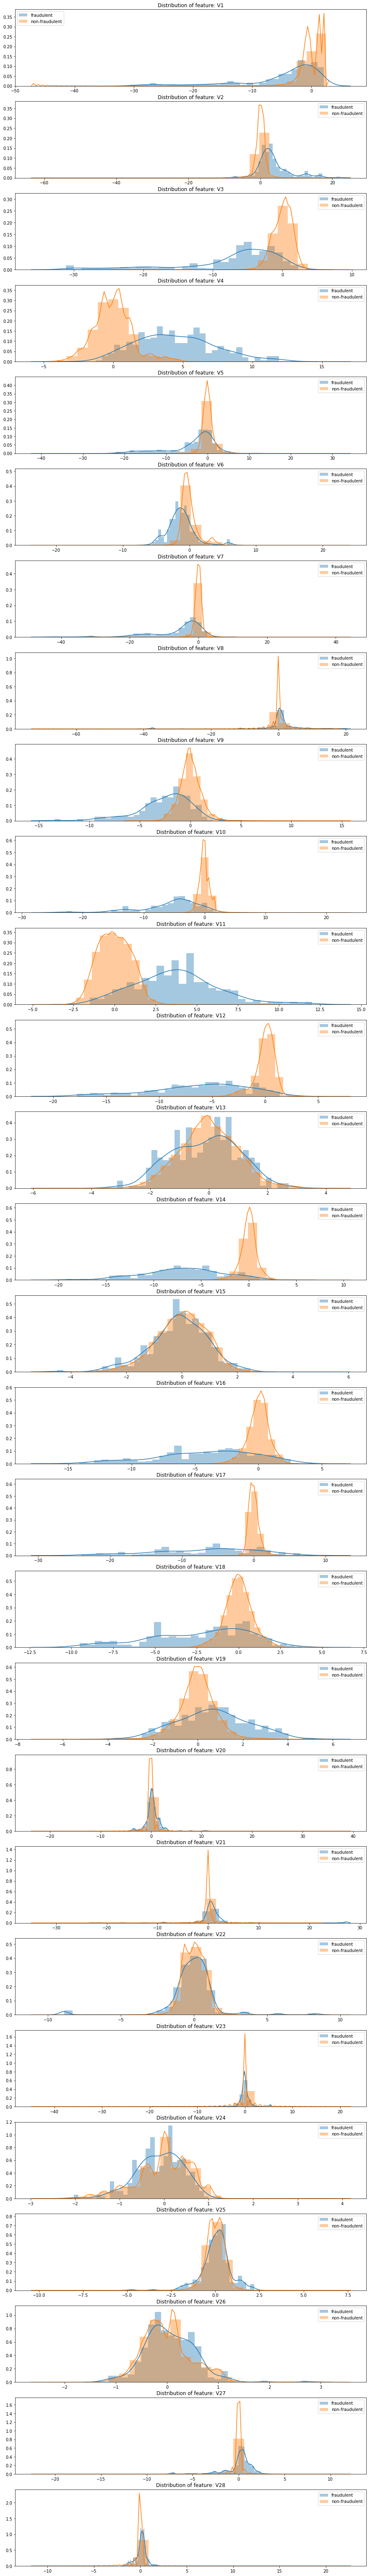

In [0]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

--> Solutions:

Table:
4 features are trained and tested. The four features are V1 to V7, V8 to V15, V16 to V23 and V24 to V28 with number of Gaussian Mixture components from 1 to 5. The table shows that Iteration 2 (training and testing the feature V8 to V15) has the best precision score and recall score whereas the Iteration 4 has the precision and recall score of zero. Thus, the best model for this case should be based on model in the iteration 2.

Graph:
Number of components of each feature is plotted vs the precision @ k =100. Again, Iteration 2 has the best performance out of the 4 features. 

Also, from plot, the precision and recall score tend to increase as the number of gaussian mixture componets increase. And, the precsion score tends to approach a constant value as number of components reach 5.

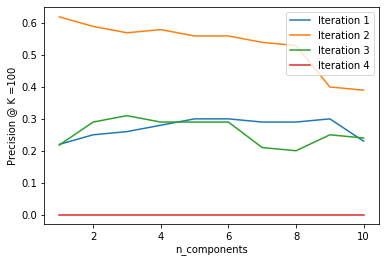

In [0]:
  #THis section is plot with Vertical axis of Precesion@k=100 and X axis of n_components
                              # Iteration 1
precision=[]
recall=[]
components=[]
for i in range(1,11):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  #gm.fit(X_train[['V1','V4','V13','V20']])
  gm.fit(X_train.iloc[:,1:7])
  #p_gm = gm.score_samples(X_test[['V1','V4','V13','V20']])
  p_gm = gm.score_samples(X_test.iloc[:,1:7])
  mn = sorted(p_gm)[99]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
  components.append(i)
  precision.append(sc)
  recall.append(r)
  
plt.plot(components,precision,label="Iteration 1")

                            # Iteration 2
precision=[]
recall=[]
components=[]

for i in range(1,11):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,8:15])
  p_gm = gm.score_samples(X_test.iloc[:,8:15])
  
  mn = sorted(p_gm)[99]
    
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

plt.plot(components,precision,label="Iteration 2")
plt.xlabel('n_components')
plt.ylabel('Precision @ K =100')
plt.legend()

                              # Iteration 3
precision=[]
recall=[]
components=[]

for i in range(1,11):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  #gm.fit(X_train[['V9','V7','V2','V22']])
  #p_gm = gm.score_samples(X_test[['V9','V7','V2','V22']])
  gm.fit(X_train.iloc[:,16:23])
  p_gm = gm.score_samples(X_test.iloc[:,16:23])
  mn = sorted(p_gm)[99]
    
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

plt.plot(components,precision,label="Iteration 3")
plt.xlabel('n_components')
plt.ylabel('Precision @ K =100')
plt.legend()
                              # Iteration 4
precision=[]
recall=[]
components=[]

for i in range(1,11):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  #gm.fit(X_train[['V8','V23','V28','V11']])
  #p_gm = gm.score_samples(X_test[['V8','V23','V28','V11']])
  gm.fit(X_train.iloc[:,20:28])
  p_gm = gm.score_samples(X_test.iloc[:,20:28])
  mn = sorted(p_gm)[99]
    
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)
plt.plot(components,precision,label="Iteration 4")
plt.xlabel('n_components')
plt.ylabel('Precision @ K =100')
plt.legend()

plt.show()

In [0]:
                                 
                                  # Iteration 1: Train and test on features: V1 to V7
 # k = 1  
precision=[]
recall=[]
k=[]
components=[] 
feature=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,1:7])
  p_gm = gm.score_samples(X_test.iloc[:,1:7])
  mn = sorted(p_gm)[0]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)
  feature.append('V1-V7')
df_components_1_k1=pd.DataFrame(components,columns=['n_Components'])
df_precision_1_k1=pd.DataFrame(precision, columns=['Precision@K = 1'])
df_reall_1_k1=pd.DataFrame(recall, columns=['Recall@k = 1'])
df_feature_1_k1=pd.DataFrame(feature, columns=['Feature'])

# k=10
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,1:7])
  p_gm = gm.score_samples(X_test.iloc[:,1:7])
  mn = sorted(p_gm)[9]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_1_k10 = pd.DataFrame(components,columns=['n_Components'])
df_precision_1_k10 = pd.DataFrame(precision, columns=['Precision@K = 10'])
df_reall_1_k10 = pd.DataFrame(recall, columns=['Recall@k = 10'])

# k=100
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  
  gm.fit(X_train.iloc[:,1:7])
  #p_gm = gm.score_samples(X_test[['V1','V4','V13','V20']])
  p_gm = gm.score_samples(X_test.iloc[:,1:7])
  mn = sorted(p_gm)[99]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_1_k100 = pd.DataFrame(components,columns=['n_Components'])
df_precision_1_k100 = pd.DataFrame(precision, columns=['Precision@K = 100'])
df_reall_1_k100 = pd.DataFrame(recall, columns=['Recall@k = 100'])

df_1 = pd.concat([df_feature_1_k1,df_components_1_k1,df_precision_1_k1,df_reall_1_k1,df_precision_1_k10,df_reall_1_k10,df_precision_1_k100,df_reall_1_k100],axis=1)
df_1                            

,Feature,n_Components,Precision@K = 1,Recall@k = 1,Precision@K = 10,Recall@k = 10,Precision@K = 100,Recall@k = 100
0,V1-V7,1,0.0,0.0,0.0,0.000000,0.22,0.135802
1,V1-V7,2,0.0,0.0,0.1,0.006173,0.25,0.154321
2,V1-V7,3,0.0,0.0,0.1,0.006173,0.26,0.160494
3,V1-V7,4,0.0,0.0,0.1,0.006173,0.28,0.172840
4,V1-V7,5,0.0,0.0,0.1,0.006173,0.30,0.185185


In [0]:
                                        # Iteration 2:Train and test on features: V8 to V15
 # k = 1  
precision=[]
recall=[]
k=[]
components=[] 
feature=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,8:15])
  p_gm = gm.score_samples(X_test.iloc[:,8:15])
  mn = sorted(p_gm)[0]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)
  feature.append('V8-V15')
df_components_2_k1=pd.DataFrame(components,columns=['n_Components'])
df_precision_2_k1=pd.DataFrame(precision, columns=['Precision@K = 1'])
df_reall_2_k1=pd.DataFrame(recall, columns=['Recall@k = 1'])
df_feature_2_k1=pd.DataFrame(feature, columns=['Feature'])

# k=10
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,8:15])
  p_gm = gm.score_samples(X_test.iloc[:,8:15])
  mn = sorted(p_gm)[9]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_2_k10 = pd.DataFrame(components,columns=['n_Components'])
df_precision_2_k10 = pd.DataFrame(precision, columns=['Precision@K = 10'])
df_reall_2_k10 = pd.DataFrame(recall, columns=['Recall@k = 10'])

# k=100
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,8:15])
  p_gm = gm.score_samples(X_test.iloc[:,8:15])
  mn = sorted(p_gm)[99]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_2_k100 = pd.DataFrame(components,columns=['n_Components'])
df_precision_2_k100 = pd.DataFrame(precision, columns=['Precision@K = 100'])
df_reall_2_k100 = pd.DataFrame(recall, columns=['Recall@k = 100'])

df_2 = pd.concat([df_feature_2_k1,df_components_2_k1,df_precision_2_k1,df_reall_2_k1,df_precision_2_k10,df_reall_2_k10,df_precision_2_k100,df_reall_2_k100],axis=1)
df_2         

,Feature,n_Components,Precision@K = 1,Recall@k = 1,Precision@K = 10,Recall@k = 10,Precision@K = 100,Recall@k = 100
0,V8-V15,1,1.0,0.006173,1.000000,0.061728,0.62,0.382716
1,V8-V15,2,1.0,0.006173,0.909091,0.061728,0.59,0.364198
2,V8-V15,3,0.0,0.000000,0.900000,0.055556,0.57,0.351852
3,V8-V15,4,1.0,0.006173,1.000000,0.061728,0.58,0.358025
4,V8-V15,5,0.0,0.000000,0.900000,0.055556,0.56,0.345679


In [0]:
                                                                          # Iteration 3:Train and test on features: V16 to V23
 # k = 1  
precision=[]
recall=[]
k=[]
components=[] 
feature=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,16:23])
  p_gm = gm.score_samples(X_test.iloc[:,16:23])
  mn = sorted(p_gm)[0]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)
  feature.append('V16-V23')
df_components_3_k1=pd.DataFrame(components,columns=['n_Components'])
df_precision_3_k1=pd.DataFrame(precision, columns=['Precision@K = 1'])
df_reall_3_k1=pd.DataFrame(recall, columns=['Recall@k = 1'])
df_feature_3_k1=pd.DataFrame(feature, columns=['Feature'])

# k=10
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,16:23])
  p_gm = gm.score_samples(X_test.iloc[:,16:23])
  mn = sorted(p_gm)[9]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_3_k10 = pd.DataFrame(components,columns=['n_Components'])
df_precision_3_k10 = pd.DataFrame(precision, columns=['Precision@K = 10'])
df_reall_3_k10 = pd.DataFrame(recall, columns=['Recall@k = 10'])

# k=100
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,16:23])
  p_gm = gm.score_samples(X_test.iloc[:,16:23])
  mn = sorted(p_gm)[99]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_3_k100 = pd.DataFrame(components,columns=['n_Components'])
df_precision_3_k100 = pd.DataFrame(precision, columns=['Precision@K = 100'])
df_reall_3_k100 = pd.DataFrame(recall, columns=['Recall@k = 100'])

df_3 = pd.concat([df_feature_3_k1,df_components_3_k1,df_precision_3_k1,df_reall_3_k1,df_precision_3_k10,df_reall_3_k10,df_precision_3_k100,df_reall_3_k100],axis=1)
df_3         

,Feature,n_Components,Precision@K = 1,Recall@k = 1,Precision@K = 10,Recall@k = 10,Precision@K = 100,Recall@k = 100
0,V16-V23,1,0.0,0.0,0.0,0.000000,0.217822,0.135802
1,V16-V23,2,0.0,0.0,0.1,0.006173,0.290000,0.179012
2,V16-V23,3,0.0,0.0,0.1,0.006173,0.310000,0.191358
3,V16-V23,4,0.0,0.0,0.1,0.006173,0.290000,0.179012
4,V16-V23,5,0.0,0.0,0.1,0.006173,0.290000,0.179012


In [0]:
# Iteration 4:Train and test on features: V24 to V28
 # k = 1  
precision=[]
recall=[]
k=[]
components=[] 
feature=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,24:28])
  p_gm = gm.score_samples(X_test.iloc[:,24:28])
  mn = sorted(p_gm)[0]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)
  feature.append('V24-V28')
df_components_4_k1=pd.DataFrame(components,columns=['n_Components'])
df_precision_4_k1=pd.DataFrame(precision, columns=['Precision@K = 1'])
df_reall_4_k1=pd.DataFrame(recall, columns=['Recall@k = 1'])
df_feature_4_k1=pd.DataFrame(feature, columns=['Feature'])

# k=10
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,24:28])
  p_gm = gm.score_samples(X_test.iloc[:,24:28])
  mn = sorted(p_gm)[9]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
    
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_4_k10 = pd.DataFrame(components,columns=['n_Components'])
df_precision_4_k10 = pd.DataFrame(precision, columns=['Precision@K = 10'])
df_reall_4_k10 = pd.DataFrame(recall, columns=['Recall@k = 10'])

# k=100
precision=[]
recall=[]
k=[]
for i in range(1,6):
  gm = GaussianMixture(n_components=i, covariance_type='full',random_state=0)
  gm.fit(X_train.iloc[:,24:28])
  p_gm = gm.score_samples(X_test.iloc[:,24:28])
  mn = sorted(p_gm)[99]  
  sc = precision_score(y_test, 1*(p_gm<=mn))
  r=recall_score(y_test, 1*(p_gm<=mn))
  components.append(i)
  precision.append(sc)
  recall.append(r)

df_components_4_k100 = pd.DataFrame(components,columns=['n_Components'])
df_precision_4_k100 = pd.DataFrame(precision, columns=['Precision@K = 100'])
df_reall_4_k100 = pd.DataFrame(recall, columns=['Recall@k = 100'])

df_4 = pd.concat([df_feature_4_k1,df_components_4_k1,df_precision_4_k1,df_reall_4_k1,df_precision_4_k10,df_reall_4_k10,df_precision_4_k100,df_reall_4_k100],axis=1)
df_4        

,Feature,n_Components,Precision@K = 1,Recall@k = 1,Precision@K = 10,Recall@k = 10,Precision@K = 100,Recall@k = 100
0,V24-V28,1,0.0,0.0,0.0,0.0,0.0,0.0
1,V24-V28,2,0.0,0.0,0.0,0.0,0.0,0.0
2,V24-V28,3,0.0,0.0,0.0,0.0,0.0,0.0
3,V24-V28,4,0.0,0.0,0.0,0.0,0.0,0.0
4,V24-V28,5,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Table: Precision and recall socre for 4 feaatures @ different K = 1, 10, 100
df_total=pd.concat([df_1,df_2,df_3,df_4],axis=0)
df_total

,Feature,n_Components,Precision@K = 1,Recall@k = 1,Precision@K = 10,Recall@k = 10,Precision@K = 100,Recall@k = 100
0,V1-V7,1,0.0,0.000000,0.000000,0.000000,0.220000,0.135802
1,V1-V7,2,0.0,0.000000,0.100000,0.006173,0.250000,0.154321
2,V1-V7,3,0.0,0.000000,0.100000,0.006173,0.260000,0.160494
3,V1-V7,4,0.0,0.000000,0.100000,0.006173,0.280000,0.172840
4,V1-V7,5,0.0,0.000000,0.100000,0.006173,0.300000,0.185185
0,V8-V15,1,1.0,0.006173,1.000000,0.061728,0.620000,0.382716
1,V8-V15,2,1.0,0.006173,0.909091,0.061728,0.590000,0.364198
2,V8-V15,3,0.0,0.000000,0.900000,0.055556,0.570000,0.351852
3,V8-V15,4,1.0,0.006173,1.000000,0.061728,0.580000,0.358025
4,V8-V15,5,0.0,0.000000,0.900000,0.055556,0.560000,0.345679
